## Set up 

In [1]:
# dataset from link 1 
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit
    
#word cloud package
try:
    import pillow
except ModuleNotFoundError:
    !pip install pillow
try:
    import wordcloud
except ModuleNotFoundError:
    !pip install wordcloud 
    
# ml and set0up packages
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  

In [2]:
pd.set_option("display.max_rows", 50)

## Set wd - only run once per session



In [3]:
default_path = r'C:\Users\sfofa\OneDrive\Documents\Stanford Classes\Grad\CS_129'
os.chdir(default_path)
%cd C:\Users\sfofa\OneDrive\Documents\Stanford Classes\Grad\CS_129
%pwd

C:\Users\sfofa


'C:\\Users\\sfofa\\OneDrive\\Documents\\Stanford Classes\\Grad\\CS_129'

## Read-in Information from Convokit Downloads


In [34]:
# Speaker-level information
speakers = pd.read_json(r'C:\Users\sfofa\OneDrive\Documents\Stanford Classes\Grad\CS_129\speakers.json')
speakers

,<UNKNOWN>,<INAUDIBLE>,j__brett_m_kavanaugh,j__neil_gorsuch,j__elena_kagan,j__sonia_sotomayor,j__samuel_a_alito_jr,j__john_g_roberts_jr,j__stephen_g_breyer,j__ruth_bader_ginsburg,...,morgan_chu,samuel_bonderoff,james_k_lehman,griffin_s_dunham,vivek_suri,mitchell_p_reich,richard_m_summa,adam_h_charnes,patrick_strawbridge,carey_r_dunne
name,<UNKNOWN>,<INAUDIBLE>,Brett M. Kavanaugh,Neil Gorsuch,Elena Kagan,Sonia Sotomayor,"Samuel A. Alito, Jr.","John G. Roberts, Jr.",Stephen G. Breyer,Ruth Bader Ginsburg,...,Morgan Chu,Samuel Bonderoff,James K. Lehman,Griffin S. Dunham,Vivek Suri,Mitchell P. Reich,Richard M. Summa,Adam H. Charnes,Patrick Strawbridge,Carey R. Dunne
type,U,U,J,J,J,J,J,J,J,J,...,A,A,A,A,A,A,A,A,A,A
role,unknown,inaudible,justice,justice,justice,justice,justice,justice,justice,justice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Utterance-level info
utts_original = pd.read_json(r'C:\Users\sfofa\OneDrive\Documents\Stanford Classes\Grad\CS_129\utterances.jsonl', lines = True)
utts_original


,id,conversation_id,text,meta,reply_to,speaker
0,13127__0_000,13127,"Number 71, Lonnie Affronti versus United State...","{'case_id': '1955_71', 'start_times': [0.0, 7....",None,j__earl_warren
1,13127__0_001,13127,May it please the Court.\nWe are here by writ ...,"{'case_id': '1955_71', 'start_times': [9.218, ...",13127__0_000,harry_f_murphy
2,13127__0_002,13127,Consecutive sentences.,"{'case_id': '1955_71', 'start_times': [48.138]...",13127__0_001,j__william_o_douglas
3,13127__0_003,13127,"Consecutive sentences.\nIn this case, the defe...","{'case_id': '1955_71', 'start_times': [49.315,...",13127__0_002,harry_f_murphy
4,13127__0_004,13127,Was the aggregate prison sentence was 20 or 25...,"{'case_id': '1955_71', 'start_times': [174.058...",13127__0_003,<INAUDIBLE>
...,...,...,...,...,...,...
1700784,24969__2_007,24969,-- has all sorts of meaning that you're not en...,"{'case_id': '2019_19-67', 'start_times': [3496...",24969__2_006,j__sonia_sotomayor
1700785,24969__2_008,24969,"No, Your Honor --","{'case_id': '2019_19-67', 'start_times': [3506...",24969__2_007,eric_j_feigin
1700786,24969__2_009,24969,-- altogether?,"{'case_id': '2019_19-67', 'start_times': [3506...",24969__2_008,j__sonia_sotomayor
1700787,24969__2_010,24969,-- we are using the principles of complicity a...,"{'case_id': '2019_19-67', 'start_times': [3507...",24969__2_009,eric_j_feigin


In [38]:
utts  = utts_original['meta'].str.split(',')

In [39]:
df = utts_original.join(pd.DataFrame(utts_original.pop('meta').values.tolist(), index=utts_original.index))

In [40]:
utts = df
#Get beginning of talking time
utts['Starts'] = utts.start_times.apply(lambda x:min(x))
#Get last talking second
utts['Stops'] = utts.stop_times.apply(lambda x:max(x))
# Total time of utterance
utts['Talk_times'] = utts['Stops'] - utts['Starts']
utts['speaker_type'] = utts['speaker_type'].astype(str)
# getting the utterances of only the justicies
utts = utts[utts['speaker_type']== 'J']

In [41]:
utts[["Year", "Case"]] = utts.case_id.str.split("_", expand = True)
utts = utts[utts['Year'] >= '1986']
utts

,id,conversation_id,text,reply_to,speaker,case_id,start_times,stop_times,speaker_type,side,timestamp,Starts,Stops,Talk_times,Year,Case
1030540,19212__0_000,19212,We will hear arguments first this afternoon in...,None,j__william_h_rehnquist,1986_84-2022,"[0.0, 14.511]","[14.511, 17.837]",J,NaN,0.000,0.000,17.837,17.837,1986,84-2022
1030542,19212__0_002,19212,The bottle price is a real price.\nIt is the r...,19212__0_001,j__antonin_scalia,1986_84-2022,"[151.97, 153.735]","[153.735, 158.201]",J,NaN,151.970,151.970,158.201,6.231,1986,84-2022
1030544,19212__0_004,19212,"In which case he wouldn't be a wholesaler, I s...",19212__0_003,j__antonin_scalia,1986_84-2022,[160.109],[162.544],J,NaN,160.109,160.109,162.544,2.435,1986,84-2022
1030546,19212__0_006,19212,"Who do you charge the bottle price to, anyway?...",19212__0_005,j__antonin_scalia,1986_84-2022,"[165.011, 166.933]","[166.933, 168.683]",J,NaN,165.011,165.011,168.683,3.672,1986,84-2022
1030548,19212__0_008,19212,If he buys one and a half cases he gets half a...,19212__0_007,j__antonin_scalia,1986_84-2022,[178.226],[181.395],J,NaN,178.226,178.226,181.395,3.169,1986,84-2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700780,24969__2_003,24969,-- what in reading this statute would give an ...,24969__2_002,j__sonia_sotomayor,2019_19-67,[3414.84],[3470.52],J,NaN,3414.840,3414.840,3470.520,55.680,2019,19-67
1700782,24969__2_005,24969,But accomplice liability --,24969__2_004,j__sonia_sotomayor,2019_19-67,[3494.88],[3495.76],J,NaN,3494.880,3494.880,3495.760,0.880,2019,19-67
1700784,24969__2_007,24969,-- has all sorts of meaning that you're not en...,24969__2_006,j__sonia_sotomayor,2019_19-67,"[3496.8, 3500.32, 3502.96, 3504.68]","[3500.32, 3502.96, 3504.68, 3506.04]",J,NaN,3496.800,3496.800,3506.040,9.240,2019,19-67
1700786,24969__2_009,24969,-- altogether?,24969__2_008,j__sonia_sotomayor,2019_19-67,[3506.56],[3507.76],J,NaN,3506.560,3506.560,3507.760,1.200,2019,19-67


In [42]:
# where are talk times < 0 
utts_negtalk = utts[utts['Talk_times'] < 0]
utts_negtalk

utts.loc[utts.Talk_times <= 0, 'Talk_times'] = 0


#num_instances = len(utts_negtalk)
# 201 instances when there is a negative talking time

## CaseInfo from 4 link

In [43]:
#With Citation
#caseinfo_original = pd.read_csv("C:/Users/sfofa/OneDrive/Documents/Stanford Classes/Grad/CS_129/Case_by_SC_Citation.csv",encoding='cp1252')
caseinfo_original = pd.read_csv("C:/Users/sfofa/OneDrive/Documents/Stanford Classes/Grad/CS_129/Case_by_SC_Docket.csv",encoding='cp1252')


In [44]:
#caseinfo = caseinfo_original[['caseId', 'dateDecision','sctCite', 'majOpinWriter', 'majOpinAssigner' ]]
caseinfo = caseinfo_original
caseinfo

,caseId,caseIssuesId,dateDecision,sctCite,chief,docket,issue,issueArea,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes,Unnamed: 13
0,1986-002,1986-002-01-01,11/4/1986,107 S. Ct. 336,Rehnquist,85-767,60010,6,104,102.0,1,6,3,NaN
1,1986-003,1986-003-01-01,11/4/1986,107 S. Ct. 347,Rehnquist,85-558,120010,12,105,102.0,1,9,0,NaN
2,1986-003,1986-003-02-01,11/4/1986,107 S. Ct. 347,Rehnquist,85-559,120010,12,105,102.0,1,9,0,NaN
3,1986-003,1986-003-03-01,11/4/1986,107 S. Ct. 347,Rehnquist,85-560,120010,12,105,102.0,1,9,0,NaN
4,1986-004,1986-004-01-01,11/12/1986,107 S. Ct. 353,Rehnquist,85-1033,80030,8,101,102.0,1,7,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,2019-070,2019-070-01-01,6/25/2020,140 S. Ct. 1959,Roberts,19-161,20110,2,112,111.0,1,7,2,NaN
3081,2019-071,2019-071-01-01,6/29/2020,140 S. Ct. 2183,Roberts,19-7,130015,13,111,111.0,1,5,4,NaN
3082,2019-072,2019-072-01-01,6/22/2020,140 S. Ct. 1936,Roberts,18-1501,80120,8,113,111.0,1,8,1,NaN
3083,2019-074,2019-074-01-01,7/9/2020,140 S. Ct. 2019,Roberts,19-715,130015,13,111,111.0,1,7,2,NaN


## Joining Datasets
caseinfo and utts

In [161]:
data = utts.join(caseinfo.set_index('docket'), on = 'Case')
#pd.option_context('display.max_rows', None)
data[["Term", "Docket"]] = data.Case.str.split("-", expand = True)

In [163]:
data['Case']

1030540    84-2022
1030542    84-2022
1030544    84-2022
1030546    84-2022
1030548    84-2022
            ...   
1700780      19-67
1700782      19-67
1700784      19-67
1700786      19-67
1700788      19-67
Name: Case, Length: 325903, dtype: object

## Analysis

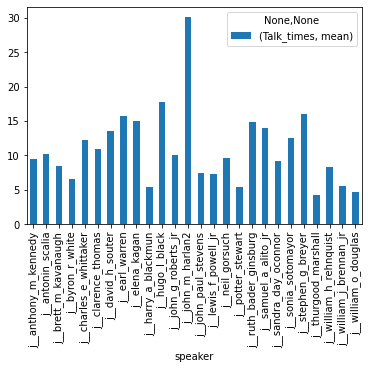

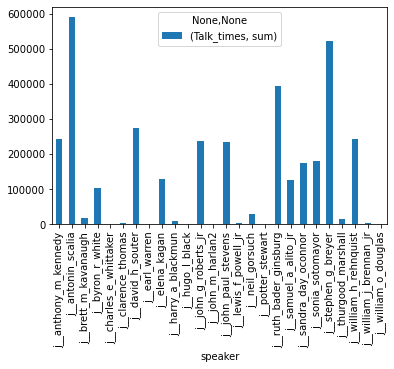

In [47]:
# See how much each justic spoke for each term
grouped_speaker_mean = data.groupby('speaker').agg({'Talk_times': ['mean']}).plot(kind= 'bar')
#print (grouped_speaker)
grouped_speaker_sum = data.groupby('speaker').agg({'Talk_times': ['sum']}).plot(kind= 'bar')
#print (grouped_speaker)
# should I extract out negative talk times - see above look at utts_negtalk

In [48]:
#total speaking time by term
data_term_speaker_sum = data.groupby(['Term', 'speaker'])['Talk_times'].sum()

##pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
#pd.set_option('display.max_colwidth', -1)

data_term_speaker_sum

Term  speaker               
00    j__anthony_m_kennedy       9453.157
      j__antonin_scalia         20101.425
      j__clarence_thomas          120.296
      j__david_h_souter         12718.157
      j__john_g_roberts_jr       2514.650
                                  ...    
99    j__john_paul_stevens       6111.262
      j__ruth_bader_ginsburg    18225.678
      j__sandra_day_oconnor      8167.902
      j__stephen_g_breyer       19939.669
      j__william_h_rehnquist    11188.058
Name: Talk_times, Length: 438, dtype: float64

In [49]:
# distribution by majOpinWriters

#first find unique cases (unique Dockets)
dist_majOpinWriters = data.groupby(['Term','majOpinWriter']).Docket.nunique()
dist_majOpinWriters

Term  majOpinWriter
00    102.0            10
      103.0             8
      104.0             7
      105.0             6
      106.0             8
                       ..
99    106.0            11
      107.0             9
      108.0             8
      109.0             6
      110.0             9
Name: Docket, Length: 324, dtype: int64

In [50]:
# distribution by majOpinAssigners
dist_majOpinAssigners = caseinfo.groupby(['majOpinAssigner']).size()
dist_majOpinAssigners

majOpinAssigner
92.0      116
95.0       33
98.0        5
100.0      26
102.0    1621
103.0     213
104.0       4
105.0      23
106.0      57
108.0      11
109.0       8
111.0     967
dtype: int64

## Dataset with Votes Information

In [51]:
case_votes = pd.read_json(r'C:\Users\sfofa\OneDrive\Documents\Stanford Classes\Grad\CS_129\cases.jsonl', lines = True)
case_votes
print(case_votes)

                id  year    citation  \
0          1955_71  1955   350 US 79   
1         1955_410  1955   351 US 79   
2         1955_351  1955  350 US 532   
3          1955_38  1955  350 US 568   
4          1955_49  1955  350 US 198   
...            ...   ...         ...   
7743    2019_19-46  2019    591 US _   
7744   2019_19-177  2019    591 US _   
7745  2019_18-1584  2019    590 US _   
7746    2019_19-67  2019    590 US _   
7747   2019_19-373  2019        None   

                                                  title  \
0                             Affronti v. United States   
1     American Airlines, Inc. v. North American Airl...   
2                                  Archawski v. Hanioti   
3                                Armstrong v. Armstrong   
4     Bernhardt v. Polygraphic Company of America, Inc.   
...                                                 ...   
7743  U.S. Patent and Trademark Office v. Booking.co...   
7744  United States Agency for International De

In [52]:
#aux dataset
case_votes = pd.read_json(r'C:\Users\sfofa\OneDrive\Documents\Stanford Classes\Grad\CS_129\cases.jsonl', lines = True)
case_votes = case_votes[['id', 'year', 'docket_no','votes_detail']]
case_votes = case_votes[case_votes['year'] >= 1986]
case_votes
case_votes['votes_detail'] =case_votes['votes_detail'].astype('str') 
case_votes['votes_detail'] = case_votes['votes_detail'].str.strip('[]').astype(str)
case_votes['votes_detail'] = case_votes['votes_detail'].str.strip('{}').astype(str)
case_votes['votes_detail'] = case_votes['votes_detail'].str.strip('[]').astype(str)

In [53]:
#case_votes  = case_votes['votes_detail'].str.split(',')
case_votes= case_votes[case_votes['votes_detail'] != 'nan']
case_votes[['vote1', 'vote2', 'vote3', 'vote4', 'vote5', 'vote6', 'vote7', 'vote8', 'vote9']] = case_votes['votes_detail'].str.split(',',8, expand=True)
case_votes


,id,year,docket_no,votes_detail,vote1,vote2,vote3,vote4,vote5,vote6,vote7,vote8,vote9
4564,1986_84-2022,1986,84-2022,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 2.0,'j__john_paul_stevens': 1.0,'j__sandra_day_oconnor': 2.0,'j__antonin_scalia': 1.0
4565,1986_86-497,1986,86-497,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 1.0,'j__john_paul_stevens': 1.0,'j__sandra_day_oconnor': 1.0,'j__antonin_scalia': 4.0
4566,1986_85-920,1986,85-920,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 1.0,'j__john_paul_stevens': 1.0,'j__sandra_day_oconnor': 1.0,'j__antonin_scalia': 1.0
4567,1986_86-357,1986,86-357,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 2.0,'j__william_h_rehnquist': 2.0,'j__john_paul_stevens': 1.0,'j__sandra_day_oconnor': 2.0,'j__antonin_scalia': 2.0
4568,1986_85-1239,1986,85-1239,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 1.0,'j__john_paul_stevens': 4.0,'j__sandra_day_oconnor': 1.0,'j__antonin_scalia': 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7742,2019_19-635,2019,19-635,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 2.0,'j__ruth_bader_ginsburg': 1.0,'j__stephen_g_breyer': 1.0,'j__samuel_a_alito_jr': 2.0,'j__sonia_sotomayor': 1.0,'j__elena_kagan': 1.0,'j__neil_gorsuch': 4.0,'j__brett_m_kavanaugh': 4.0
7743,2019_19-46,2019,19-46,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 1.0,'j__ruth_bader_ginsburg': 1.0,'j__stephen_g_breyer': 2.0,'j__samuel_a_alito_jr': 1.0,'j__sonia_sotomayor': 3.0,'j__elena_kagan': 1.0,'j__neil_gorsuch': 1.0,'j__brett_m_kavanaugh': 1.0
7744,2019_19-177,2019,19-177,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 3.0,'j__ruth_bader_ginsburg': 2.0,'j__stephen_g_breyer': 2.0,'j__samuel_a_alito_jr': 1.0,'j__sonia_sotomayor': 2.0,'j__elena_kagan': -1.0,'j__neil_gorsuch': 1.0,'j__brett_m_kavanaugh': 1.0
7745,2019_18-1584,2019,18-1584,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 1.0,'j__ruth_bader_ginsburg': 1.0,'j__stephen_g_breyer': 1.0,'j__samuel_a_alito_jr': 1.0,'j__sonia_sotomayor': 2.0,'j__elena_kagan': 2.0,'j__neil_gorsuch': 1.0,'j__brett_m_kavanaugh': 1.0


In [54]:
import warnings
warnings.filterwarnings("ignore")

case_votes["vote1"][case_votes['vote1'].str.contains("2.0") | case_votes['vote1'].str.contains("4.0") |case_votes['vote1'].str.contains("6.0") | case_votes['vote1'].str.contains("7.0") |case_votes['vote1'].str.contains("8.0")] = "against"
case_votes["vote2"][case_votes['vote2'].str.contains("2.0") | case_votes['vote2'].str.contains("4.0") |case_votes['vote2'].str.contains("6.0") | case_votes['vote2'].str.contains("7.0") |case_votes['vote2'].str.contains("8.0")] = "against"
case_votes["vote3"][case_votes['vote3'].str.contains("2.0") | case_votes['vote3'].str.contains("4.0") |case_votes['vote3'].str.contains("6.0") | case_votes['vote3'].str.contains("7.0") |case_votes['vote3'].str.contains("8.0")] = "against"
case_votes["vote4"][case_votes['vote4'].str.contains("2.0") | case_votes['vote4'].str.contains("4.0") |case_votes['vote4'].str.contains("6.0") | case_votes['vote4'].str.contains("7.0") |case_votes['vote4'].str.contains("8.0")] = "against"
case_votes["vote5"][case_votes['vote5'].str.contains("2.0") | case_votes['vote5'].str.contains("4.0") |case_votes['vote5'].str.contains("6.0") | case_votes['vote5'].str.contains("7.0") |case_votes['vote5'].str.contains("8.0")] = "against"
case_votes["vote6"][case_votes['vote6'].str.contains("2.0") | case_votes['vote6'].str.contains("4.0") |case_votes['vote6'].str.contains("6.0") | case_votes['vote6'].str.contains("7.0") |case_votes['vote6'].str.contains("8.0")] = "against"
case_votes["vote7"][case_votes['vote7'].str.contains("2.0") | case_votes['vote7'].str.contains("4.0") |case_votes['vote7'].str.contains("6.0") | case_votes['vote7'].str.contains("7.0") |case_votes['vote7'].str.contains("8.0")] = "against"
case_votes["vote8"][case_votes['vote8'].str.contains("2.0") | case_votes['vote8'].str.contains("4.0") |case_votes['vote8'].str.contains("6.0") | case_votes['vote8'].str.contains("7.0") |case_votes['vote8'].str.contains("8.0")] = "against"
case_votes["vote9"][case_votes['vote9'].str.contains("2.0") | case_votes['vote9'].str.contains("4.0") |case_votes['vote9'].str.contains("6.0") | case_votes['vote9'].str.contains("7.0") |case_votes['vote9'].str.contains("8.0")] = "against"
case_votes

,id,year,docket_no,votes_detail,vote1,vote2,vote3,vote4,vote5,vote6,vote7,vote8,vote9
4564,1986_84-2022,1986,84-2022,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,against,'j__john_paul_stevens': 1.0,against,'j__antonin_scalia': 1.0
4565,1986_86-497,1986,86-497,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 1.0,'j__john_paul_stevens': 1.0,'j__sandra_day_oconnor': 1.0,against
4566,1986_85-920,1986,85-920,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 1.0,'j__john_paul_stevens': 1.0,'j__sandra_day_oconnor': 1.0,'j__antonin_scalia': 1.0
4567,1986_86-357,1986,86-357,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,against,against,'j__john_paul_stevens': 1.0,against,against
4568,1986_85-1239,1986,85-1239,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",'j__thurgood_marshall': 1.0,'j__william_j_brennan_jr': 1.0,'j__byron_r_white': 1.0,'j__harry_a_blackmun': 1.0,'j__lewis_f_powell_jr': 1.0,'j__william_h_rehnquist': 1.0,against,'j__sandra_day_oconnor': 1.0,against
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7742,2019_19-635,2019,19-635,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,against,'j__ruth_bader_ginsburg': 1.0,'j__stephen_g_breyer': 1.0,against,'j__sonia_sotomayor': 1.0,'j__elena_kagan': 1.0,against,against
7743,2019_19-46,2019,19-46,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 1.0,'j__ruth_bader_ginsburg': 1.0,against,'j__samuel_a_alito_jr': 1.0,'j__sonia_sotomayor': 3.0,'j__elena_kagan': 1.0,'j__neil_gorsuch': 1.0,'j__brett_m_kavanaugh': 1.0
7744,2019_19-177,2019,19-177,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 3.0,against,against,'j__samuel_a_alito_jr': 1.0,against,'j__elena_kagan': -1.0,'j__neil_gorsuch': 1.0,'j__brett_m_kavanaugh': 1.0
7745,2019_18-1584,2019,18-1584,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",'j__john_g_roberts_jr': 1.0,'j__clarence_thomas': 1.0,'j__ruth_bader_ginsburg': 1.0,'j__stephen_g_breyer': 1.0,'j__samuel_a_alito_jr': 1.0,against,against,'j__neil_gorsuch': 1.0,'j__brett_m_kavanaugh': 1.0


In [61]:
#change judgenames
col_selected = ['vote1', 'vote2', 'vote3', 'vote4', 'vote5', 'vote6', 'vote7', 'vote8', 'vote9']
#case_votes.loc[case_votes['vote1', 'vote2'].str.contains('marshall'), 'vote1'] = 'j__thurgood_marshall'
case_votes['vote1'] = case_votes['vote1'].str.replace(r"'","")
case_votes['vote1'] = case_votes['vote1'].str.replace('\d+',"")
case_votes['vote1'] = case_votes['vote1'].str.replace(r":","")
case_votes['vote1'] = case_votes['vote1'].str.replace(r".","")
case_votes


1
vote1
2
vote2
3
vote3
4
vote4
5
vote5
6
vote6
7
vote7
8
vote8
9
vote9


In [62]:
for num in range(1,10):
    current = num
    current = str(current)
    vote_col = "vote" + current
    case_votes[vote_col] = case_votes[vote_col].str.replace(r"'","")
    case_votes[vote_col] = case_votes[vote_col].str.replace('\d+',"")
    case_votes[vote_col] = case_votes[vote_col].str.replace(r":","")
    case_votes[vote_col] = case_votes[vote_col].str.replace(r".","")

In [63]:
case_votes

,id,year,docket_no,votes_detail,vote1,vote2,vote3,vote4,vote5,vote6,vote7,vote8,vote9
4564,1986_84-2022,1986,84-2022,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,against,j__john_paul_stevens,against,j__antonin_scalia
4565,1986_86-497,1986,86-497,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,j__william_h_rehnquist,j__john_paul_stevens,j__sandra_day_oconnor,against
4566,1986_85-920,1986,85-920,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,j__william_h_rehnquist,j__john_paul_stevens,j__sandra_day_oconnor,j__antonin_scalia
4567,1986_86-357,1986,86-357,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,against,against,j__john_paul_stevens,against,against
4568,1986_85-1239,1986,85-1239,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,j__william_h_rehnquist,against,j__sandra_day_oconnor,against
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7742,2019_19-635,2019,19-635,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,against,j__sonia_sotomayor,j__elena_kagan,against,against
7743,2019_19-46,2019,19-46,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,j__ruth_bader_ginsburg,against,j__samuel_a_alito_jr,j__sonia_sotomayor,j__elena_kagan,j__neil_gorsuch,j__brett_m_kavanaugh
7744,2019_19-177,2019,19-177,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,against,against,j__samuel_a_alito_jr,against,j__elena_kagan -,j__neil_gorsuch,j__brett_m_kavanaugh
7745,2019_18-1584,2019,18-1584,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,j__ruth_bader_ginsburg,j__stephen_g_breyer,j__samuel_a_alito_jr,against,against,j__neil_gorsuch,j__brett_m_kavanaugh


## Join all Datasets

In [164]:
case_votes = case_votes.rename(columns= {'id': 'cv_id', 'year':'cv_year'})
case_votes
data = data.join(case_votes.set_index('docket_no'), on = 'Case')

In [111]:
# all info together
data


,id,conversation_id,text,reply_to,speaker,case_id,start_times,stop_times,speaker_type,side,...,votes_detail,vote1,vote2,vote3,vote4,vote5,vote6,vote7,vote8,vote9
1030540,19212__0_000,19212,We will hear arguments first this afternoon in...,None,j__william_h_rehnquist,1986_84-2022,"[0.0, 14.511]","[14.511, 17.837]",J,NaN,...,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,against,j__john_paul_stevens,against,j__antonin_scalia
1030542,19212__0_002,19212,The bottle price is a real price.\nIt is the r...,19212__0_001,j__antonin_scalia,1986_84-2022,"[151.97, 153.735]","[153.735, 158.201]",J,NaN,...,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,against,j__john_paul_stevens,against,j__antonin_scalia
1030544,19212__0_004,19212,"In which case he wouldn't be a wholesaler, I s...",19212__0_003,j__antonin_scalia,1986_84-2022,[160.109],[162.544],J,NaN,...,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,against,j__john_paul_stevens,against,j__antonin_scalia
1030546,19212__0_006,19212,"Who do you charge the bottle price to, anyway?...",19212__0_005,j__antonin_scalia,1986_84-2022,"[165.011, 166.933]","[166.933, 168.683]",J,NaN,...,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,against,j__john_paul_stevens,against,j__antonin_scalia
1030548,19212__0_008,19212,If he buys one and a half cases he gets half a...,19212__0_007,j__antonin_scalia,1986_84-2022,[178.226],[181.395],J,NaN,...,"'j__thurgood_marshall': 1.0, 'j__william_j_bre...",j__thurgood_marshall,j__william_j_brennan_jr,j__byron_r_white,j__harry_a_blackmun,j__lewis_f_powell_jr,against,j__john_paul_stevens,against,j__antonin_scalia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1700780,24969__2_003,24969,-- what in reading this statute would give an ...,24969__2_002,j__sonia_sotomayor,2019_19-67,[3414.84],[3470.52],J,NaN,...,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,j__ruth_bader_ginsburg,j__stephen_g_breyer,j__samuel_a_alito_jr,j__sonia_sotomayor,j__elena_kagan,j__neil_gorsuch,j__brett_m_kavanaugh
1700782,24969__2_005,24969,But accomplice liability --,24969__2_004,j__sonia_sotomayor,2019_19-67,[3494.88],[3495.76],J,NaN,...,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,j__ruth_bader_ginsburg,j__stephen_g_breyer,j__samuel_a_alito_jr,j__sonia_sotomayor,j__elena_kagan,j__neil_gorsuch,j__brett_m_kavanaugh
1700784,24969__2_007,24969,-- has all sorts of meaning that you're not en...,24969__2_006,j__sonia_sotomayor,2019_19-67,"[3496.8, 3500.32, 3502.96, 3504.68]","[3500.32, 3502.96, 3504.68, 3506.04]",J,NaN,...,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,j__ruth_bader_ginsburg,j__stephen_g_breyer,j__samuel_a_alito_jr,j__sonia_sotomayor,j__elena_kagan,j__neil_gorsuch,j__brett_m_kavanaugh
1700786,24969__2_009,24969,-- altogether?,24969__2_008,j__sonia_sotomayor,2019_19-67,[3506.56],[3507.76],J,NaN,...,"'j__john_g_roberts_jr': 1.0, 'j__clarence_thom...",j__john_g_roberts_jr,j__clarence_thomas,j__ruth_bader_ginsburg,j__stephen_g_breyer,j__samuel_a_alito_jr,j__sonia_sotomayor,j__elena_kagan,j__neil_gorsuch,j__brett_m_kavanaugh


In [165]:
# sub-select 
data = data.drop(['conversation_id','reply_to','case_id', 'start_times', 
                 'stop_times','speaker_type','side', 'timestamp','Unnamed: 13',
                 'votes_detail', 'Year', 'splitVote','majVotes','minVotes', 'cv_id','cv_year'], axis =1)  
data = data.drop(['caseId', 'Starts','Stops'], axis =1)
for col in data.columns: 
    print(col) 


id
text
speaker
Talk_times
Case
caseIssuesId
dateDecision
sctCite
chief
issue
issueArea
majOpinWriter
majOpinAssigner
Term
Docket
vote1
vote2
vote3
vote4
vote5
vote6
vote7
vote8
vote9


In [136]:
##data_recover = data
data_recover = data.copy()

## NLTK

In [74]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
try:
    import textblob
except ModuleNotFoundError:
    !pip install textblob


#see https://data-science-blog.com/en/blog/2018/11/04/sentiment-analysis-using-python/

ModuleNotFoundError: No module named 'textblob'

In [143]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sfofa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [209]:
import nltk.stem as stemmer
stemmer = PorterStemmer()
from textblob import TextBlob

In [137]:
data.shape

(326349, 23)

In [138]:
data['text'] = data['text'].astype(str)

In [139]:
## Before lowercasing
data['text']

1030540    We will hear arguments first this afternoon in...
1030542    The bottle price is a real price.\nIt is the r...
1030544    In which case he wouldn't be a wholesaler, I s...
1030546    Who do you charge the bottle price to, anyway?...
1030548    If he buys one and a half cases he gets half a...
                                 ...                        
1700780    -- what in reading this statute would give an ...
1700782                          But accomplice liability --
1700784    -- has all sorts of meaning that you're not en...
1700786                                       -- altogether?
1700788          Thank you, counsel.\nThe case is submitted.
Name: text, Length: 326349, dtype: object

In [140]:
##Lowercase all reviews
data['text'] = data['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['text'] = data['text'].astype(str)
data['text']

1030540    we will hear arguments first this afternoon in...
1030542    the bottle price is a real price. it is the re...
1030544    in which case he wouldn't be a wholesaler, i s...
1030546    who do you charge the bottle price to, anyway?...
1030548    if he buys one and a half cases he gets half a...
                                 ...                        
1700780    -- what in reading this statute would give an ...
1700782                          but accomplice liability --
1700784    -- has all sorts of meaning that you're not en...
1700786                                       -- altogether?
1700788           thank you, counsel. the case is submitted.
Name: text, Length: 326349, dtype: object

In [123]:
data['text'] = data['text'].astype(str)
data.dtypes

id                  object
text                object
speaker             object
Talk_times         float64
caseIssuesId        object
dateDecision        object
sctCite             object
chief               object
issue              float64
issueArea          float64
majOpinWriter      float64
majOpinAssigner    float64
Term                object
Docket              object
vote1               object
vote2               object
vote3               object
vote4               object
vote5               object
vote6               object
vote7               object
vote8               object
vote9               object
dtype: object

In [141]:
## remove punctuation
data['text'] = data['text'].astype(str)
data['text'] = data['text'].str.replace('[^\w\s]','')
data['text'] 

1030540    we will hear arguments first this afternoon in...
1030542    the bottle price is a real price it is the rea...
1030544    in which case he wouldnt be a wholesaler i sup...
1030546    who do you charge the bottle price to anyway w...
1030548    if he buys one and a half cases he gets half a...
                                 ...                        
1700780     what in reading this statute would give an av...
1700782                            but accomplice liability 
1700784     has all sorts of meaning that youre not endor...
1700786                                           altogether
1700788              thank you counsel the case is submitted
Name: text, Length: 326349, dtype: object

In [144]:
## stopwords
stop = stopwords.words('english')
data['text'] = data['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['text']

1030540    hear arguments first afternoon 842022 324 liqu...
1030542    bottle price real price real price wholesaler ...
1030544                      case wouldnt wholesaler suppose
1030546    charge bottle price anyway wholesaler charge b...
1030548      buys one half cases gets half case bottle price
                                 ...                        
1700780    reading statute would give average person noti...
1700782                                 accomplice liability
1700784    sorts meaning youre endorsing youre saying aid...
1700786                                           altogether
1700788                         thank counsel case submitted
Name: text, Length: 326349, dtype: object

In [158]:
##testing jointext joins
data = {'name':  ['name1','name1','name1','name1', 'name2','name2','name2','name2'],
        'string': ['hej', 'du','aj','oj','fin', 'katt', 'mycket', 'lite'],
        'month':['1','1','2','3','4','4','5','4']}
df = pd.DataFrame (data, columns = ['name', 'string', 'month'])
print(df)

    name  string month
0  name1     hej     1
1  name1      du     1
2  name1      aj     2
3  name1      oj     3
4  name2     fin     4
5  name2    katt     4
6  name2  mycket     5
7  name2    lite     4


In [159]:
df =df.groupby(['name','month'])['string'].apply(' '.join).reset_index()
df

,name,month,string
0,name1,1,hej du
1,name1,2,aj
2,name1,3,oj
3,name2,4,fin katt lite
4,name2,5,mycket


In [166]:
## data_talk is a set for all utterances of each speaker by case 
data_talk = data.groupby(['Case', 'speaker'])['text'].apply(' '.join).reset_index()
data_talk

,Case,speaker,text
0,00-1011,j__anthony_m_kennedy,Suppose there's a case in which it's conceded ...
1,00-1011,j__antonin_scalia,You say the legal validity of his deportation ...
2,00-1011,j__david_h_souter,But your claim is that you are entitled to an ...
3,00-1011,j__john_paul_stevens,Could I just interrupt you with one quick... ...
4,00-1011,j__ruth_bader_ginsburg,"Mr. Guttentag, may I just add a post script on..."
...,...,...,...
20578,99-936,j__john_paul_stevens,"--May I ask, Ms. Smith, was this the same prog..."
20579,99-936,j__ruth_bader_ginsburg,Suppose they had reasons-- --to have arrests. ...
20580,99-936,j__sandra_day_oconnor,"What is DSS, please? Is there not a routine ur..."
20581,99-936,j__stephen_g_breyer,"Could a doctor today, when he thinks... he has..."


In [185]:
data_time = data.groupby(['Case', 'speaker'])['Talk_times'].sum()
data_time

Case     speaker               
00-1011  j__anthony_m_kennedy      278.094
         j__antonin_scalia         294.739
         j__david_h_souter         253.447
         j__john_paul_stevens       87.366
         j__ruth_bader_ginsburg    165.107
                                    ...   
99-936   j__john_paul_stevens       65.644
         j__ruth_bader_ginsburg    373.952
         j__sandra_day_oconnor     186.590
         j__stephen_g_breyer       357.859
         j__william_h_rehnquist    102.040
Name: Talk_times, Length: 20583, dtype: float64

In [186]:
data_time = pd.DataFrame(data_time).reset_index()

,dt_Case,dt_speaker,Talk_times
0,00-1011,j__anthony_m_kennedy,278.094
1,00-1011,j__antonin_scalia,294.739
2,00-1011,j__david_h_souter,253.447
3,00-1011,j__john_paul_stevens,87.366
4,00-1011,j__ruth_bader_ginsburg,165.107
...,...,...,...
20578,99-936,j__john_paul_stevens,65.644
20579,99-936,j__ruth_bader_ginsburg,373.952
20580,99-936,j__sandra_day_oconnor,186.590
20581,99-936,j__stephen_g_breyer,357.859


In [180]:
data_order = data.sort_values(['Case', 'speaker'], ascending = [True, True])
data_order.shape

(326349, 24)

In [187]:
join_1 = pd.merge(data_talk, data_time, on=['Case', 'speaker'] )
join_1 = join_1.rename(columns= {'speaker': 'by_speaker', 'text':'total_text', 'Talk_times':'total_talk_times'})
join_1

,Case,speaker,text,Talk_times
0,00-1011,j__anthony_m_kennedy,Suppose there's a case in which it's conceded ...,278.094
1,00-1011,j__antonin_scalia,You say the legal validity of his deportation ...,294.739
2,00-1011,j__david_h_souter,But your claim is that you are entitled to an ...,253.447
3,00-1011,j__john_paul_stevens,Could I just interrupt you with one quick... ...,87.366
4,00-1011,j__ruth_bader_ginsburg,"Mr. Guttentag, may I just add a post script on...",165.107
...,...,...,...,...
20578,99-936,j__john_paul_stevens,"--May I ask, Ms. Smith, was this the same prog...",65.644
20579,99-936,j__ruth_bader_ginsburg,Suppose they had reasons-- --to have arrests. ...,373.952
20580,99-936,j__sandra_day_oconnor,"What is DSS, please? Is there not a routine ur...",186.590
20581,99-936,j__stephen_g_breyer,"Could a doctor today, when he thinks... he has...",357.859


In [188]:
join_1 = join_1.rename(columns= {'speaker': 'by_speaker', 'text':'total_text', 'Talk_times':'total_talk_times'})
join_1

,Case,by_speaker,total_text,total_talk_times
0,00-1011,j__anthony_m_kennedy,Suppose there's a case in which it's conceded ...,278.094
1,00-1011,j__antonin_scalia,You say the legal validity of his deportation ...,294.739
2,00-1011,j__david_h_souter,But your claim is that you are entitled to an ...,253.447
3,00-1011,j__john_paul_stevens,Could I just interrupt you with one quick... ...,87.366
4,00-1011,j__ruth_bader_ginsburg,"Mr. Guttentag, may I just add a post script on...",165.107
...,...,...,...,...
20578,99-936,j__john_paul_stevens,"--May I ask, Ms. Smith, was this the same prog...",65.644
20579,99-936,j__ruth_bader_ginsburg,Suppose they had reasons-- --to have arrests. ...,373.952
20580,99-936,j__sandra_day_oconnor,"What is DSS, please? Is there not a routine ur...",186.590
20581,99-936,j__stephen_g_breyer,"Could a doctor today, when he thinks... he has...",357.859


In [228]:
joined = join_1.join(data.set_index('Case'), on = 'Case')

In [229]:
joined = joined.drop_duplicates(subset = ['Case', 'by_speaker'])
joined

,Case,by_speaker,total_text,total_talk_times,id,text,speaker,Talk_times,caseIssuesId,dateDecision,...,Docket,vote1,vote2,vote3,vote4,vote5,vote6,vote7,vote8,vote9
0,00-1011,j__anthony_m_kennedy,Suppose there's a case in which it's conceded ...,278.094,21477__0_000,"We'll hear argument now in Number 00-1011, Deb...",j__william_h_rehnquist,12.982,2000-079-01-01,6/25/2001,...,1011,against,j__john_paul_stevens,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
1,00-1011,j__antonin_scalia,You say the legal validity of his deportation ...,294.739,21477__0_000,"We'll hear argument now in Number 00-1011, Deb...",j__william_h_rehnquist,12.982,2000-079-01-01,6/25/2001,...,1011,against,j__john_paul_stevens,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
2,00-1011,j__david_h_souter,But your claim is that you are entitled to an ...,253.447,21477__0_000,"We'll hear argument now in Number 00-1011, Deb...",j__william_h_rehnquist,12.982,2000-079-01-01,6/25/2001,...,1011,against,j__john_paul_stevens,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
3,00-1011,j__john_paul_stevens,Could I just interrupt you with one quick... ...,87.366,21477__0_000,"We'll hear argument now in Number 00-1011, Deb...",j__william_h_rehnquist,12.982,2000-079-01-01,6/25/2001,...,1011,against,j__john_paul_stevens,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
4,00-1011,j__ruth_bader_ginsburg,"Mr. Guttentag, may I just add a post script on...",165.107,21477__0_000,"We'll hear argument now in Number 00-1011, Deb...",j__william_h_rehnquist,12.982,2000-079-01-01,6/25/2001,...,1011,against,j__john_paul_stevens,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20578,99-936,j__john_paul_stevens,"--May I ask, Ms. Smith, was this the same prog...",65.644,22240__0_000,"We'll hear argument now in Number 99-936, Crys...",j__william_h_rehnquist,9.572,2000-034-01-01,3/21/2001,...,936,against,j__john_paul_stevens,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
20579,99-936,j__ruth_bader_ginsburg,Suppose they had reasons-- --to have arrests. ...,373.952,22240__0_000,"We'll hear argument now in Number 99-936, Crys...",j__william_h_rehnquist,9.572,2000-034-01-01,3/21/2001,...,936,against,j__john_paul_stevens,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
20580,99-936,j__sandra_day_oconnor,"What is DSS, please? Is there not a routine ur...",186.590,22240__0_000,"We'll hear argument now in Number 99-936, Crys...",j__william_h_rehnquist,9.572,2000-034-01-01,3/21/2001,...,936,against,j__john_paul_stevens,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer
20581,99-936,j__stephen_g_breyer,"Could a doctor today, when he thinks... he has...",357.859,22240__0_000,"We'll hear argument now in Number 99-936, Crys...",j__william_h_rehnquist,9.572,2000-034-01-01,3/21/2001,...,936,against,j__john_paul_stevens,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer


In [230]:
joined = joined.drop(['text', 'speaker', 'Talk_times'], axis =1) 

## with NLTK

In [231]:
joined['total_text'] = joined['total_text'].astype(str)

In [232]:
##Lowercase all utterances
joined['total_text'] = joined['total_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
joined['total_text'] = joined['total_text'].astype(str)
joined['total_text']

0        suppose there's a case in which it's conceded ...
1        you say the legal validity of his deportation ...
2        but your claim is that you are entitled to an ...
3        could i just interrupt you with one quick... d...
4        mr. guttentag, may i just add a post script on...
                               ...                        
20578    --may i ask, ms. smith, was this the same prog...
20579    suppose they had reasons-- --to have arrests. ...
20580    what is dss, please? is there not a routine ur...
20581    could a doctor today, when he thinks... he has...
20582    we'll hear argument now in number 99-936, crys...
Name: total_text, Length: 20583, dtype: object

In [233]:
## remove punctuation
joined['total_text'] = joined['total_text'].astype(str)
joined['total_text'] = joined['total_text'].str.replace('[^\w\s]','')
joined['total_text'] 


0        suppose theres a case in which its conceded th...
1        you say the legal validity of his deportation ...
2        but your claim is that you are entitled to an ...
3        could i just interrupt you with one quick do y...
4        mr guttentag may i just add a post script on t...
                               ...                        
20578    may i ask ms smith was this the same program i...
20579    suppose they had reasons to have arrests they ...
20580    what is dss please is there not a routine urin...
20581    could a doctor today when he thinks he has a p...
20582    well hear argument now in number 99936 crystal...
Name: total_text, Length: 20583, dtype: object

In [234]:
## stopwords
stop = stopwords.words('english')
joined['total_text'] = joined['total_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
joined['total_text']

0        suppose theres case conceded attorney general ...
1        say legal validity deportation issue respect c...
2        claim entitled adjudication administrative lev...
3        could interrupt one quick concede conviction p...
4        mr guttentag may add post script question supp...
                               ...                        
20578    may ask ms smith program instituted hospital h...
20579    suppose reasons arrests turned information soc...
20580    dss please routine urine specimen collected so...
20581    could doctor today thinks pregnant woman think...
20582    well hear argument number 99936 crystal fergus...
Name: total_text, Length: 20583, dtype: object

In [235]:
## stemming
joined['total_text'] = joined['total_text'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
joined['total_text']

0        suppos there case conced attorney gener discre...
1        say legal valid deport issu respect claim prop...
2        claim entitl adjud administr level ultim attor...
3        could interrupt one quick conced convict prior...
4        mr guttentag may add post script question supp...
                               ...                        
20578    may ask ms smith program institut hospit hospi...
20579    suppos reason arrest turn inform social servic...
20580    dss pleas routin urin specimen collect someon ...
20581    could doctor today think pregnant woman think ...
20582    well hear argument number 99936 crystal fergus...
Name: total_text, Length: 20583, dtype: object

In [236]:
## Sentiment Score
def senti(x):
    return TextBlob(x).sentiment

#1st score: sentiment polarity which tells if the sentiment is + or - 
#2nd score: subjectivitiy to tell how subjective that text is
joined['senti_score'] = joined['total_text'].apply(senti)


In [237]:
joined_copy = joined.copy()

In [238]:
sentiment_series = joined['senti_score'].tolist()
columns = ['polarity', 'subjectivity']
joined[['polarity', 'subjectivity']] = pd.DataFrame(sentiment_series, columns=columns, index=joined.index)

In [239]:
joined

,Case,by_speaker,total_text,total_talk_times,id,caseIssuesId,dateDecision,sctCite,chief,issue,...,vote3,vote4,vote5,vote6,vote7,vote8,vote9,senti_score,polarity,subjectivity
0,00-1011,j__anthony_m_kennedy,suppos there case conced attorney gener discre...,278.094,21477__0_000,2000-079-01-01,6/25/2001,121 S. Ct. 2268,Rehnquist,20110.0,...,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(-0.09766666666666668, 0.8383333333333333)",-0.097667,0.838333
1,00-1011,j__antonin_scalia,say legal valid deport issu respect claim prop...,294.739,21477__0_000,2000-079-01-01,6/25/2001,121 S. Ct. 2268,Rehnquist,20110.0,...,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.04550691244239632, 0.4472990271377368)",0.045507,0.447299
2,00-1011,j__david_h_souter,claim entitl adjud administr level ultim attor...,253.447,21477__0_000,2000-079-01-01,6/25/2001,121 S. Ct. 2268,Rehnquist,20110.0,...,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(-0.14375, 0.6335648148148149)",-0.143750,0.633565
3,00-1011,j__john_paul_stevens,could interrupt one quick conced convict prior...,87.366,21477__0_000,2000-079-01-01,6/25/2001,121 S. Ct. 2268,Rehnquist,20110.0,...,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.11465201465201466, 0.32875457875457875)",0.114652,0.328755
4,00-1011,j__ruth_bader_ginsburg,mr guttentag may add post script question supp...,165.107,21477__0_000,2000-079-01-01,6/25/2001,121 S. Ct. 2268,Rehnquist,20110.0,...,against,against,j__anthony_m_kennedy,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.006084656084656088, 0.47619047619047616)",0.006085,0.476190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20578,99-936,j__john_paul_stevens,may ask ms smith program institut hospit hospi...,65.644,22240__0_000,2000-034-01-01,3/21/2001,121 S. Ct. 1281,Rehnquist,10050.0,...,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.26825396825396824, 0.40238095238095234)",0.268254,0.402381
20579,99-936,j__ruth_bader_ginsburg,suppos reason arrest turn inform social servic...,373.952,22240__0_000,2000-034-01-01,3/21/2001,121 S. Ct. 1281,Rehnquist,10050.0,...,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.07319444444444444, 0.4193055555555556)",0.073194,0.419306
20580,99-936,j__sandra_day_oconnor,dss pleas routin urin specimen collect someon ...,186.590,22240__0_000,2000-034-01-01,3/21/2001,121 S. Ct. 1281,Rehnquist,10050.0,...,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.08138888888888889, 0.4896428571428571)",0.081389,0.489643
20581,99-936,j__stephen_g_breyer,could doctor today think pregnant woman think ...,357.859,22240__0_000,2000-034-01-01,3/21/2001,121 S. Ct. 1281,Rehnquist,10050.0,...,j__sandra_day_oconnor,against,against,j__david_h_souter,against,j__ruth_bader_ginsburg,j__stephen_g_breyer,"(0.22619946091644202, 0.4808086253369271)",0.226199,0.480809


## Basic logisitic model
w/o votes and only with senti scores - no text

In [ ]:
utts = utts[utts['Year'] >= '1986']

In [242]:
logit = joined.drop(['id','total_text','senti_score', 'vote1','vote2','vote3','vote4','vote5','vote6','vote7', 'vote8','vote9'], axis =1)



In [243]:
y = logit['majOpinWriter']
logit = joined.drop(['majOpinWriter'], axis =1)

In [255]:
print(len(logit))
print(len(y))
X = pd.concat([pd.Series(1, index=logit.index, name='00'), logit], axis=1)

20583
20583


In [256]:
def hypothesis(theta, X):
    return 1 / (1 + np.exp(-(np.dot(theta, X.T)))) - 0.0000001

def cost(X, y, theta):
    y1 = hypothesis(X, theta)
    return -(1/len(X)) * np.sum(y*np.log(y1) + (1-y)*np.log(1-y1))

In [257]:
y.unique()

array([103., 107., 109., 106., 104., 105., 110., 102., 108.,  nan, 111.,
       112., 113., 114., 115., 116., 101., 100.,  98.,  92.,  95.])

In [258]:
y1 = np.zeros([logit.shape[0], len(y.unique())])
y1 = pd.DataFrame(y1)

In [259]:
for i in range(0, len(y.unique())):
    for j in range(0, len(y1)):
        if y[j] == y.unique()[i]:
            y1.iloc[j, i] = 1
        else: 
            y1.iloc[j, i] = 0
y1.head()


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
def gradient_descent(X, y, theta, alpha, epochs):
    m = len(X)
    for i in range(0, epochs):
        for j in range(0, 10):
            theta = pd.DataFrame(theta)
            h = hypothesis(theta.iloc[:,j], X)
            for k in range(0, theta.shape[0]):
                theta.iloc[k, j] -= (alpha/m) * np.sum((h-y.iloc[:, j])*X.iloc[:, k])
            theta = pd.DataFrame(theta)
    return theta, cost

In [261]:
theta = np.zeros([df.shape[1]+1, y1.shape[1]])
theta = gradient_descent(logit, y1, theta, 0.02, 1500)

ValueError: shapes (4,) and (26,20583) not aligned: 4 (dim 0) != 26 (dim 0)

In [262]:
joined.to_csv('sc_data.csv')